In [1]:
import pandas as pd
import numpy as np
import os
import nltools as nlt
import nilearn as nil
import nibabel as nib
import warnings

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
pd.set_option('display.max_rows', 99)

## Behavioral data

In [3]:
#load behavioral data

import dev_wtp_io_utils
behavioral_data_path = '/gpfs/projects/sanlab/shared/DEV/nonbids_data/Tasks/WTP/output/'
[run_list, run_event_df_list, run_event_stage_df_list] = dev_wtp_io_utils.get_comprehensive_run_data_from_mat_dir(behavioral_data_path)



subject 040, subject 039, subject 168, subject 063, subject 129, subject 067, subject 150, subject 159, 
SUBJ 159, 2, run14
no data for this run.
subject 004, subject 091, subject 180, subject 008, subject 095, subject 099, subject 032, 
SUBJ 032, 2, run2
no data for this run.
subject 036, subject 171, subject 100, 
SUBJ 100, 3, run2
no data for this run.
subject 109, subject 041, subject 060, subject 059, subject 130, subject 064, subject 068, subject 001, subject 087, subject 192, subject 005, subject 121, subject 999, 
SUBJ 999, 2, run1
no data for this run.


SUBJ 999, 2, run2
Data for this run is not in the expected format or is missing. Skipping this run.
time: 29-Oct-2020 17:09:09

StartTime: 3035.874545661

Jitter: array of length 16

TrialStart: array of length 2

ISI: array of length 2

FoodOn: array of length 2

BidOn: array of length 2

FoodOnset: array of length 2

BidOnset: array of length 2

FoodDuration: array of length 2

BidDuration: array of length 2

FoodPic: array 

## Design data

In [4]:
betas = pd.read_csv("../data/DEV QC and Exclusions - betas_machine_readable.csv")

In [5]:
wtp_betas = betas[betas.task=='WTP betas']

In [6]:
#get the betas just for the four runs

wtp_betas_runfiles = wtp_betas[[bt in ['run1','run2','run3','run4'] for bt in wtp_betas.type]].copy()

#number them

wtp_betas_runfiles['event_id'] = wtp_betas_runfiles.groupby('type').cumcount()+1

Now we can combine the behavioral data and the design file.

In [7]:
wtp_behavdesign = wtp_betas_runfiles.merge(run_event_df_list, how='left',
                         left_on=['type','event_id'],
                        right_on=['run','event_id'])

In [8]:
wtp_behavdesign.sample(5)

beta  type       task  event_id   isi_pre       onset  \
29519  beta_0074.nii  run4  WTP betas        11  0.665879  116.690428   
12236  beta_0024.nii  run2  WTP betas         3  1.780283   30.039246   
17662  beta_0033.nii  run2  WTP betas        12  0.925946  127.160174   
1418   beta_0003.nii  run1  WTP betas         3  1.000000   16.323951   
1847   beta_0003.nii  run1  WTP betas         3  1.780283   30.049854   

       duration           food_pic  food_num                cond health_cond  \
29519  6.532955     creamsicle.bmp        11  unhealthy_disliked   unhealthy   
12236  6.526767  HardBoiledEgg.bmp         3       healthy_liked     healthy   
17662  6.532658  oatmealcookie.bmp        12  unhealthy_disliked   unhealthy   
1418   6.533021  BabybelCheese.bmp         3       healthy_liked     healthy   
1847   6.527831   VeggieStraws.bmp         3       healthy_liked     healthy   

      liking_cond  liking_rating response  isi_post         end   run  wave  \
29519    disliked              1        5  0.925946  123.223383  run4     2   
12236       liked              4        7  0.095117   36.566013  run2     2   
17662    disliked              2        5  0.670865  133.692832  run2     2   
1418        liked              4        2  1.000000   22.856972  run1     5   
1847        liked              4        7  0.095117   36.577686  run1     2   

      subject  
29519  DEV157  
12236  DEV108  
17662  DEV139  
1418   DEV153  
1847   DEV137

## Neural data and combine


Great - now we should be able to write a script to import these in nltools and then truncate them.

In [9]:
#https://nltools.org/api.html

In [10]:
subject_dir = '/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/WTP/wave1/betaseries/sub-DEV049/'

In [11]:
subject_behavdesign = wtp_behavdesign[(wtp_behavdesign.subject=='DEV049') & (wtp_behavdesign.wave==1)].copy()
subject_behavdesign.sort_values(['run','event_id'],inplace=True)

### Doing some learning

https://nilearn.github.io/auto_examples/plot_decoding_tutorial.html#sphx-glr-auto-examples-plot-decoding-tutorial-py

Next: load the choices from the MAT files

In [12]:
subject_mask_filepath = '/gpfs/projects/sanlab/shared/DEV/bids_data/derivatives/fmriprep/sub-DEV049/anat/sub-DEV049_T1w_space-MNI152NLin2009cAsym_brainmask.nii.gz'

generic_mask_filepath = '/projects/sanlab/shared/spm12/canonical/MNI152_T1_1mm_brain_mask.nii'

#### nltools

https://nltools.org/auto_examples/02_Analysis/plot_multivariate_prediction.html#sphx-glr-auto-examples-02-analysis-plot-multivariate-prediction-py

In [13]:
#set path for the betas

beta_path_sub049 = os.listdir(subject_dir)

#iterate through the subjects
# TO DO
#iterate through and check all the betas exist
for betafile in subject_behavdesign.beta:
    betafilepath = subject_dir + betafile
    
    #check if file exists
    if os.path.exists(betafilepath):
        print('.',end='')
    else:
        raise Exception("beta " + betafile + ' does not exist')

print("...verified that all expected betas exist!",flush=True)



#import them, but catch a very specific warning and don't show it because it gets annoying
#https://docs.python.org/3/library/warnings.html
with warnings.catch_warnings(record=True) as w:
    subj_data = nlt.Brain_Data([subject_dir + b for b in subject_behavdesign.beta],
                              X=subject_behavdesign)
na_inf_warn_count=0
for wi in w:
    if wi.message.args[0]!='NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.':
        warnings.warn(wi.message,type(wi))
    else:
        na_inf_warn_count+=1
        
if na_inf_warn_count>0:
    print("caught "+ str(na_inf_warn_count) + " instances of the warning:\n" + 
         'NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.')
        


...................................................................verified that all expected betas exist!
caught 64 instances of the warning:
NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.


In [14]:
from nilearn.image import mean_img

In [15]:
from nilearn import plotting

In [16]:
#set path for the betas

beta_path_sub049 = os.listdir(subject_dir)

#iterate through the subjects
# TO DO
#iterate through and check all the betas exist
for betafile in subject_behavdesign.beta:
    betafilepath = subject_dir + betafile
    
    #check if file exists
    if os.path.exists(betafilepath):
        print('.',end='')
    else:
        raise Exception("beta " + betafile + ' does not exist')

print("...verified that all expected betas exist!",flush=True)

beta_files = [subject_dir + b for b in subject_behavdesign.beta]

from nilearn import image
subj_data = image.load_img(beta_files)

print('images_loaded')


...................................................................verified that all expected betas exist!
images_loaded


In [17]:
subj_data.shape

(97, 115, 97, 64)

visualize

### mask follow-up

What's the correct mask to use? It should be something matching the dimensions of the brain image, right?

In [18]:
from nilearn import image

In [38]:
anat_dir = "/gpfs/projects/sanlab/shared/DEV/bids_data/derivatives/fmriprep/sub-DEV049/anat/"

In [40]:
os.listdir(anat_dir)

['sub-DEV049_T1w_class-CSF_probtissue.nii.gz',
 'sub-DEV049_T1w_preproc.nii.gz',
 'sub-DEV049_T1w_space-MNI152NLin2009cAsym_class-GM_probtissue.nii.gz',
 'sub-DEV049_T1w_space-MNI152NLin2009cAsym_brainmask.nii.gz',
 'sub-DEV049_T1w_dtissue.nii.gz',
 'sub-DEV049_T1w_pial.L.surf.gii',
 'sub-DEV049_T1w_smoothwm.L.surf.gii',
 'sub-DEV049_T1w_space-MNI152NLin2009cAsym_class-CSF_probtissue.nii.gz',
 'sub-DEV049_T1w_smoothwm.R.surf.gii',
 'sub-DEV049_T1w_inflated.R.surf.gii',
 'sub-DEV049_T1w_space-MNI152NLin2009cAsym_target-T1w_warp.h5',
 'sub-DEV049_T1w_label-aparcaseg_roi.nii.gz',
 'sub-DEV049_T1w_midthickness.L.surf.gii',
 'sub-DEV049_T1w_brainmask.nii.gz',
 'sub-DEV049_T1w_label-aseg_roi.nii.gz',
 'sub-DEV049_T1w_midthickness.R.surf.gii',
 'sub-DEV049_T1w_class-WM_probtissue.nii.gz',
 'sub-DEV049_T1w_space-MNI152NLin2009cAsym_preproc.nii.gz',
 'sub-DEV049_T1w_target-MNI152NLin2009cAsym_warp.h5',
 'sub-DEV049_T1w_space-MNI152NLin2009cAsym_dtissue.nii.gz',
 'sub-DEV049_T1w_space-MNI152NLin

In [41]:

generic_mask_filepath = '/projects/sanlab/shared/spm12/canonical/MNI152_T1_1mm_brain_mask.nii'
subject_mni_mask_filepath = '/gpfs/projects/sanlab/shared/DEV/bids_data/derivatives/fmriprep/sub-DEV049/anat/sub-DEV049_T1w_space-MNI152NLin2009cAsym_brainmask.nii.gz'
subject_mask_filepath= 'sub-DEV049_T1w_brainmask.nii.gz


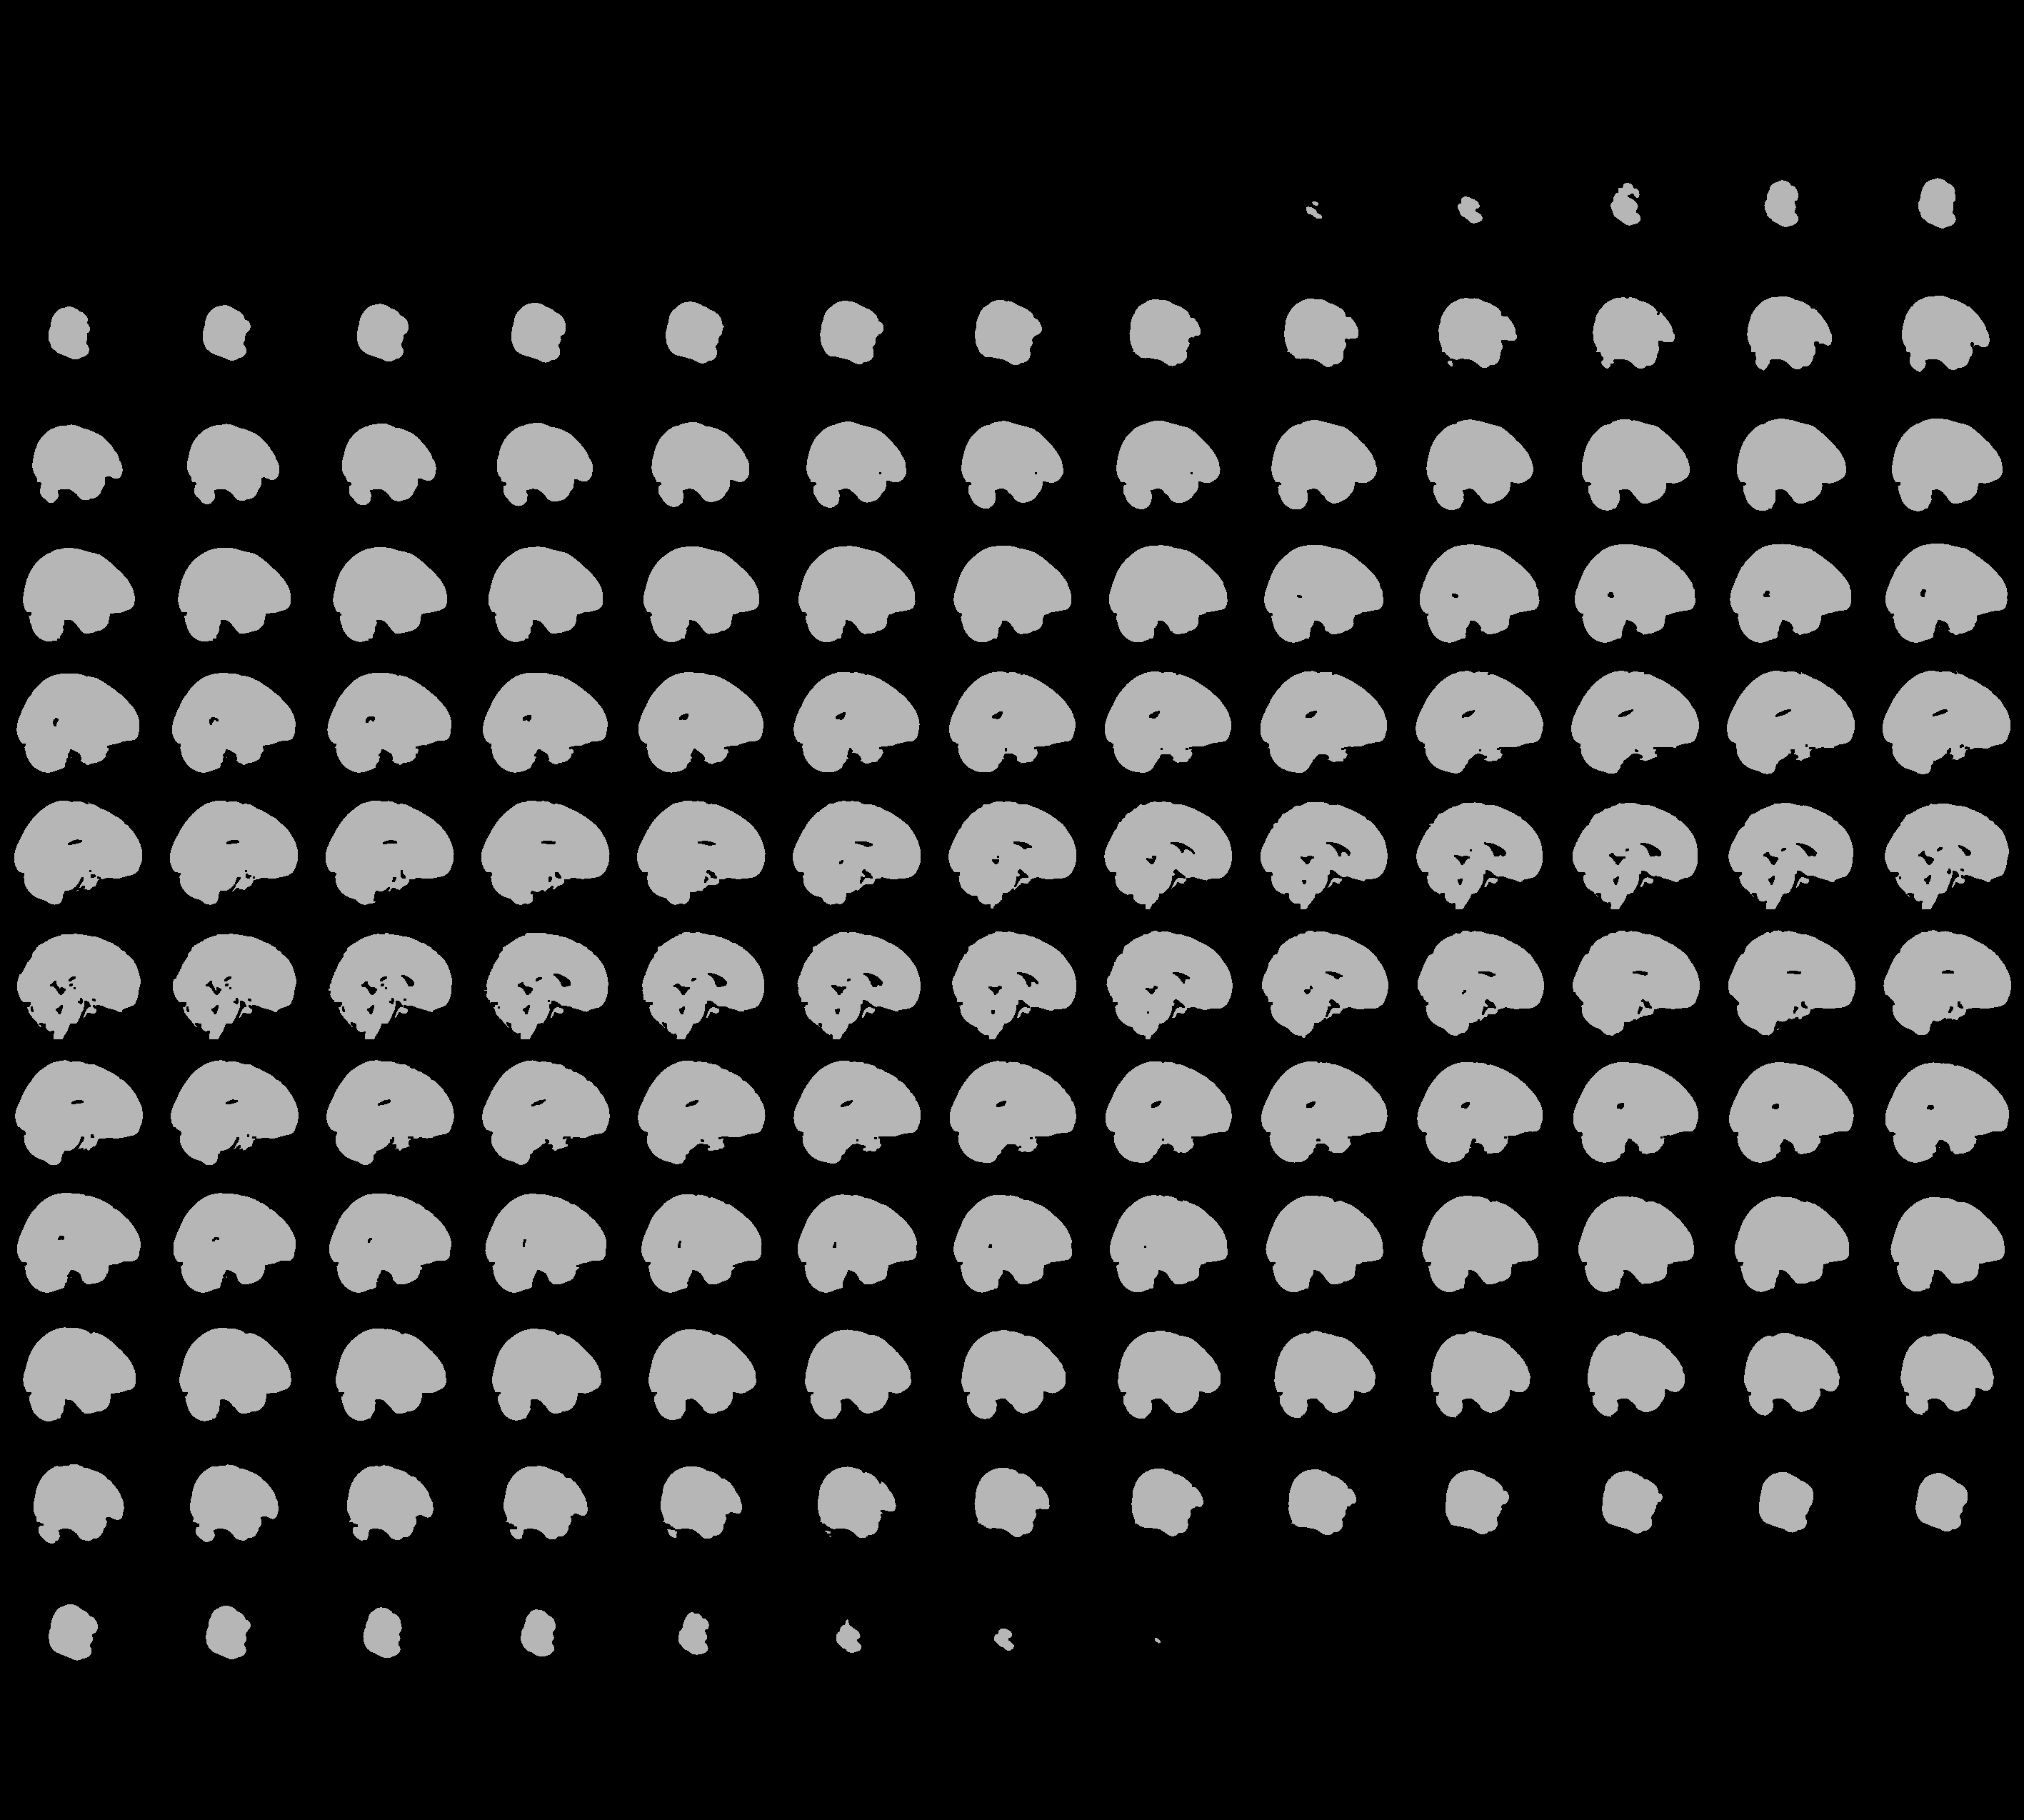
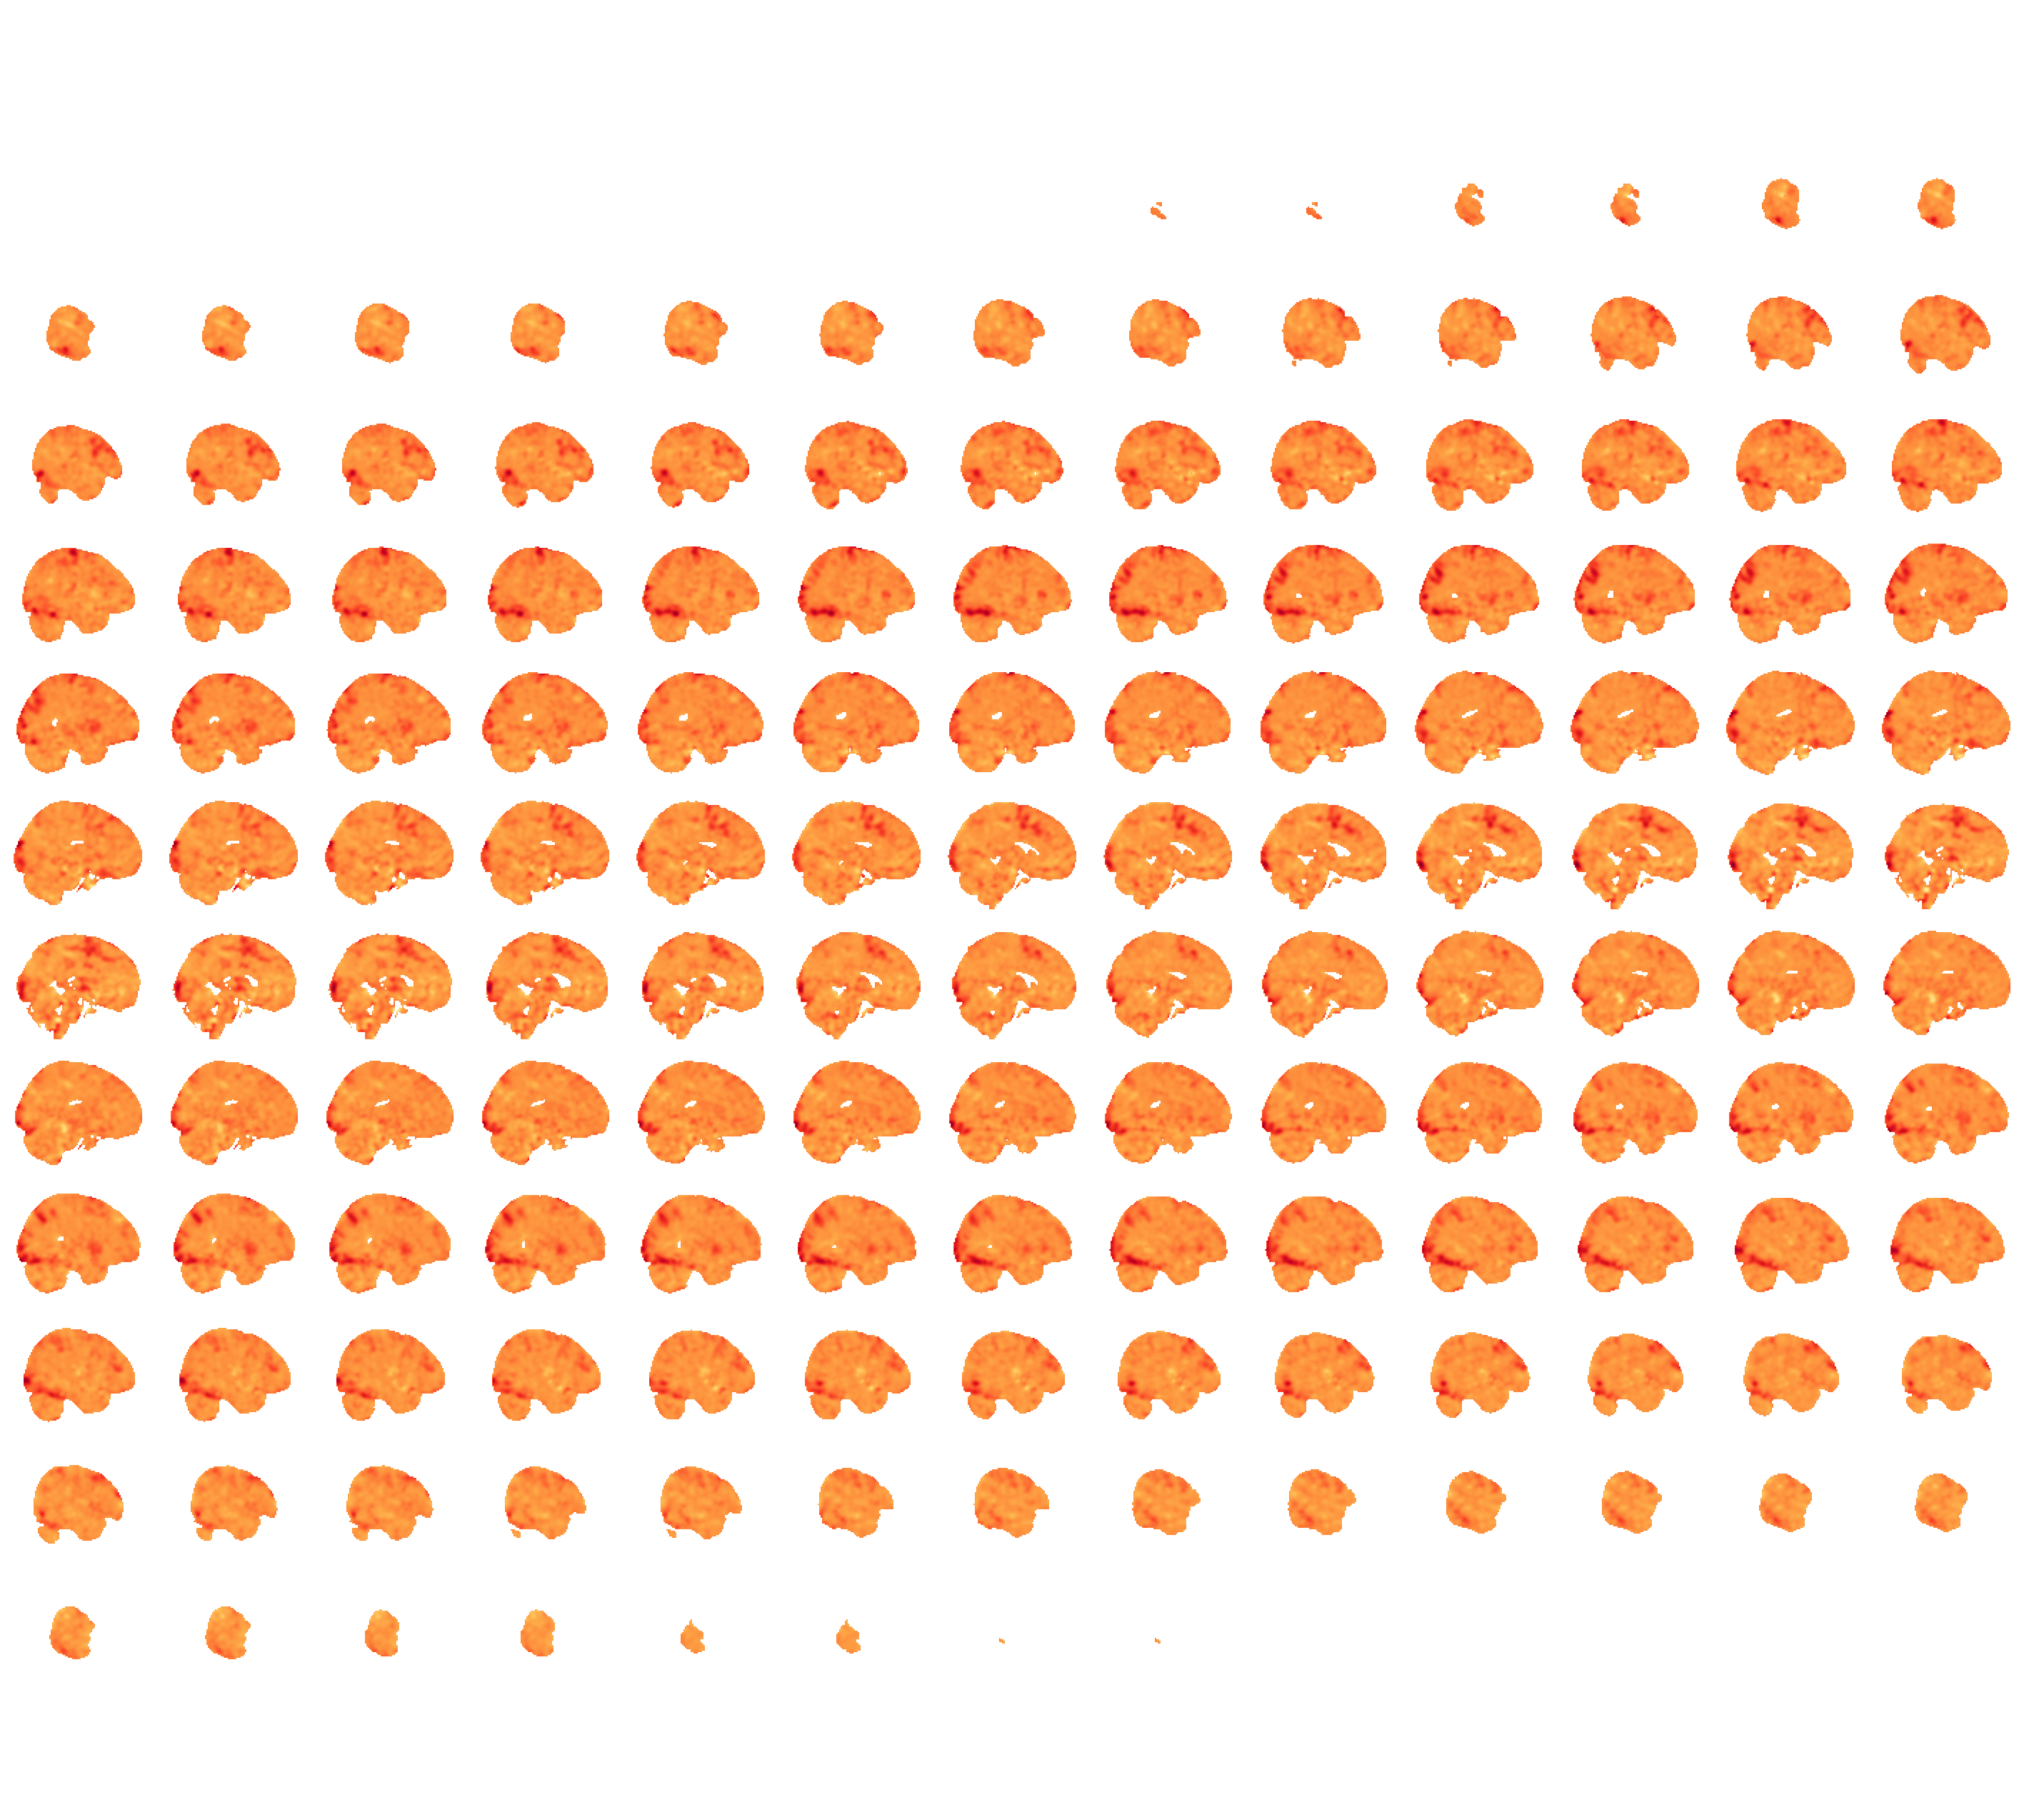

In [42]:
plotting.view_img(image.mean_img(subj_data),bg_img=generic_mask_filepath,opacity=0.7,cmap='YlOrRd')

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


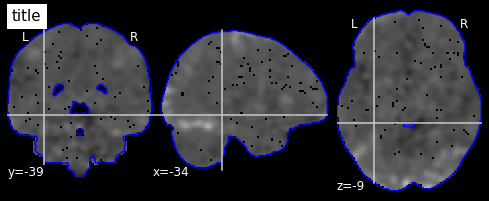

In [43]:
display = plotting.plot_anat(image.mean_img(subj_data),title='title',
                             cut_coords=[-34, -39, -9],threshold=0.01)
display.add_contours(generic_mask_img,levels=[0.5], colors='b')

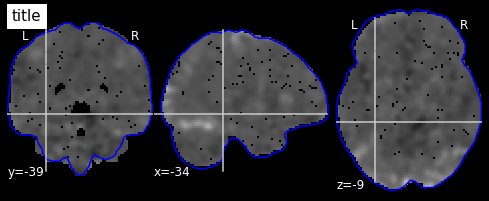

In [44]:
display = plotting.plot_anat(image.mean_img(subj_data),title='title',
                             cut_coords=[-34, -39, -9],threshold=0.01)
display.add_contours(subject_mni_mask_filepath,levels=[0.5], colors='b')

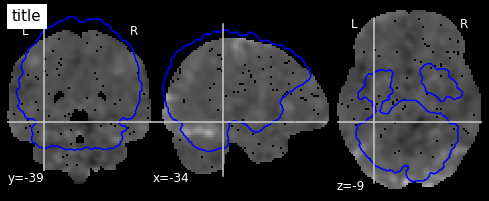

In [45]:
display = plotting.plot_anat(image.mean_img(subj_data),title='title',
                             cut_coords=[-34, -39, -9],threshold=0.01)
display.add_contours(subject_mask_filepath,levels=[0.5], colors='b')

Also nope!

In [32]:
non_finite_vals = (np.isfinite(image.mean_img(subj_data).get_fdata())==False).astype(int)
non_finite_img = nib.Nifti1Image(non_finite_vals,subj_data.affine)
finite_vals = np.isfinite(image.mean_img(subj_data).get_fdata()).astype(int)
finite_img = nib.Nifti1Image(finite_vals,subj_data.affine)

In [33]:
finite_vals.sum()

228328

In [34]:
(finite_vals & non_finite_vals).sum()

0

In [35]:
non_finite_vals.sum()

853707

In [36]:
non_finite_img.get_fdata()[40,40,50]

0.0

In [63]:
nib.save(non_finite_img,'non_finite_img.nii.gz')

In [64]:
nib.save(finite_img,'finite_img.nii.gz')

In [46]:
image.mean_img(subj_data).affine

array([[   2.,    0.,    0.,  -96.],
       [   0.,    2.,    0., -132.],
       [   0.,    0.,    2.,  -78.],
       [   0.,    0.,    0.,    1.]])

In [47]:
generic_mask_img = nib.load(generic_mask_filepath)
subject_mni_mask_img = nib.load(subject_mni_mask_filepath)
subject_mask_img = nib.load(subject_mask_filepath)

In [48]:
generic_mask_img.affine

array([[  -1.,    0.,    0.,   90.],
       [   0.,    1.,    0., -126.],
       [   0.,    0.,    1.,  -72.],
       [   0.,    0.,    0.,    1.]])

In [49]:
subject_mni_mask_img.affine

array([[   1.,    0.,    0.,  -96.],
       [   0.,    1.,    0., -132.],
       [   0.,    0.,    1.,  -78.],
       [   0.,    0.,    0.,    1.]])

In [52]:
np.round(subject_mask_img.affine,4)

array([[ 9.998000e-01, -1.380000e-02,  1.530000e-02, -1.264178e+02],
       [ 1.380000e-02,  9.999000e-01,  3.000000e-04, -1.532034e+02],
       [-1.530000e-02, -0.000000e+00,  9.999000e-01, -1.434391e+02],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  1.000000e+00]])

Regarding resampling:

https://neurostars.org/t/how-does-niftimasker-work-when-dealing-with-mask-and-data-images-of-different-resolutions/4892

https://github.com/nilearn/nilearn/blob/679ff38923629d0e31b7098fd88200b988aab5f8/nilearn/input_data/base_masker.py#L80

Asked a question here. Let's see how that goes, and move on to perhaps importing multiple subjects' data.

https://neurostars.org/t/how-to-verify-that-resampling-is-not-invalidating-my-decoder-in-nilearn/19413

## still some confusion though...

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/image/resampling.py:273: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "



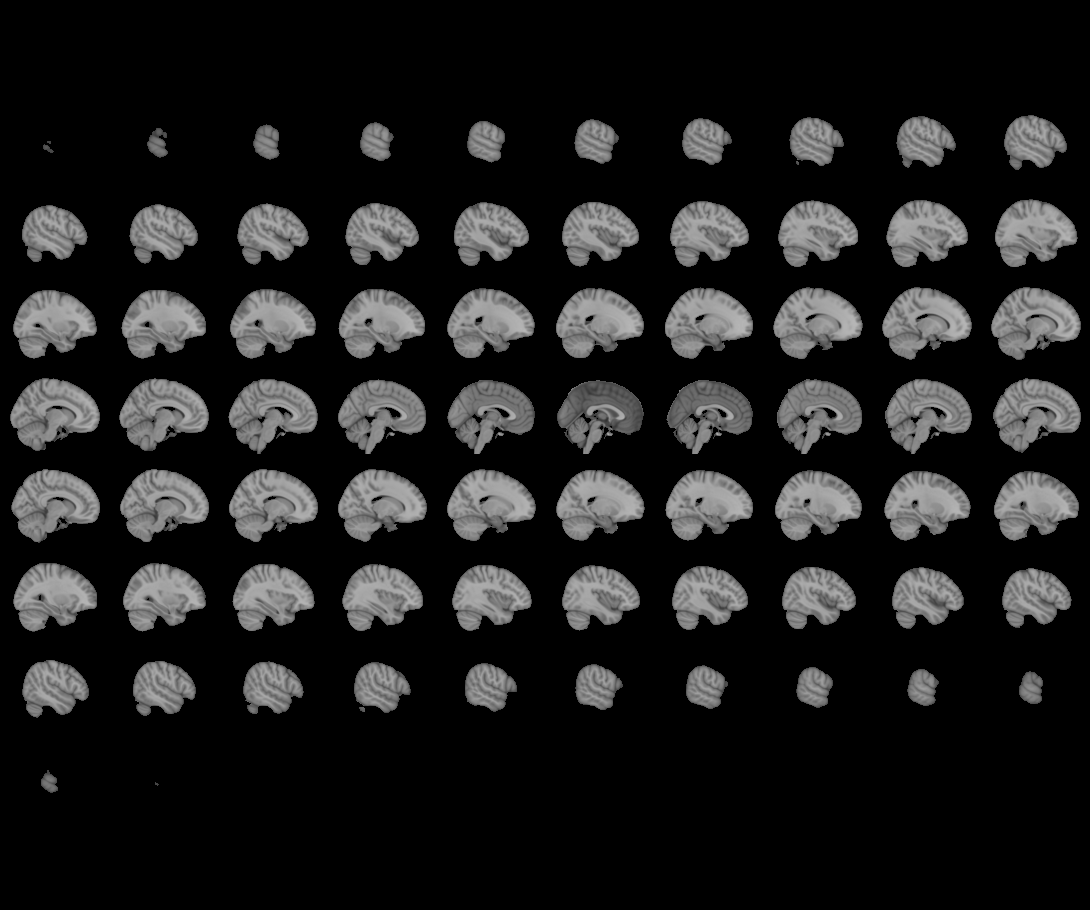
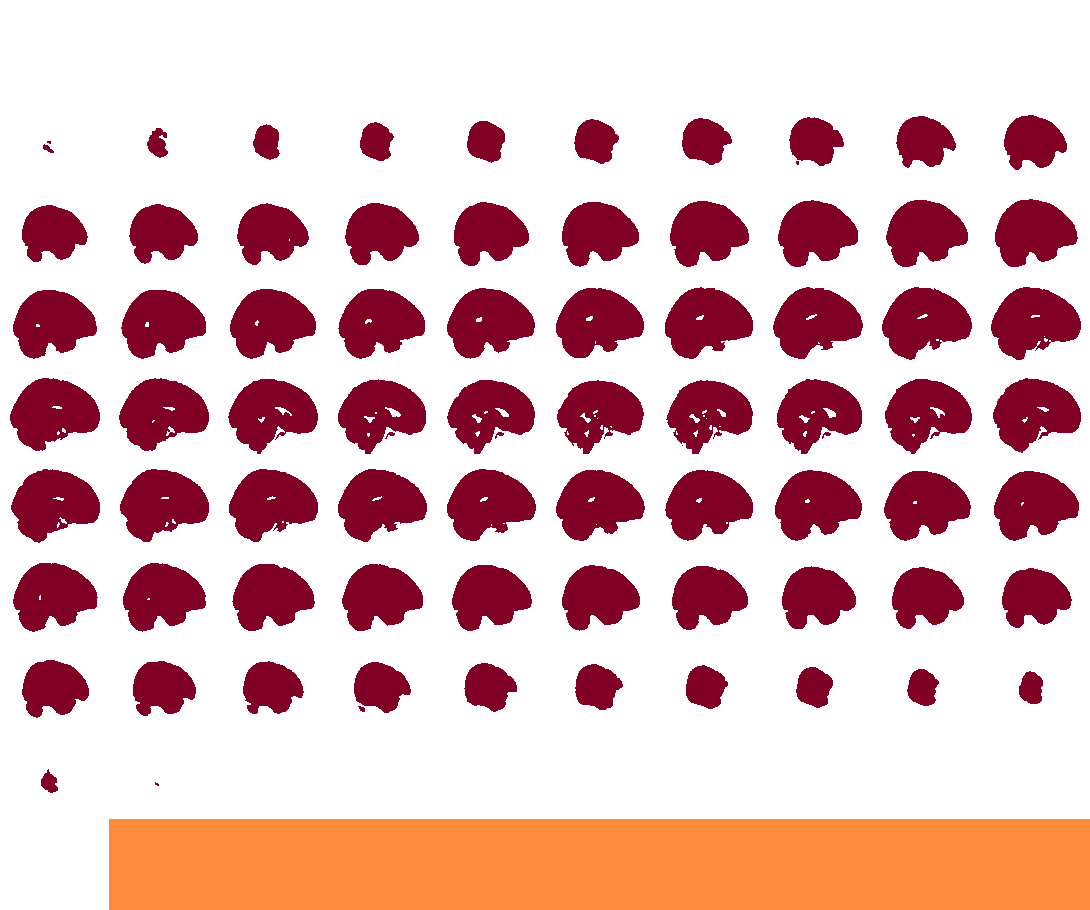

In [55]:
generic_mask_filepath = '/projects/sanlab/shared/spm12/canonical/MNI152_T1_1mm_brain_mask.nii'
plotting.view_img(generic_mask_filepath,opacity=0.7,cmap='YlOrRd')

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(



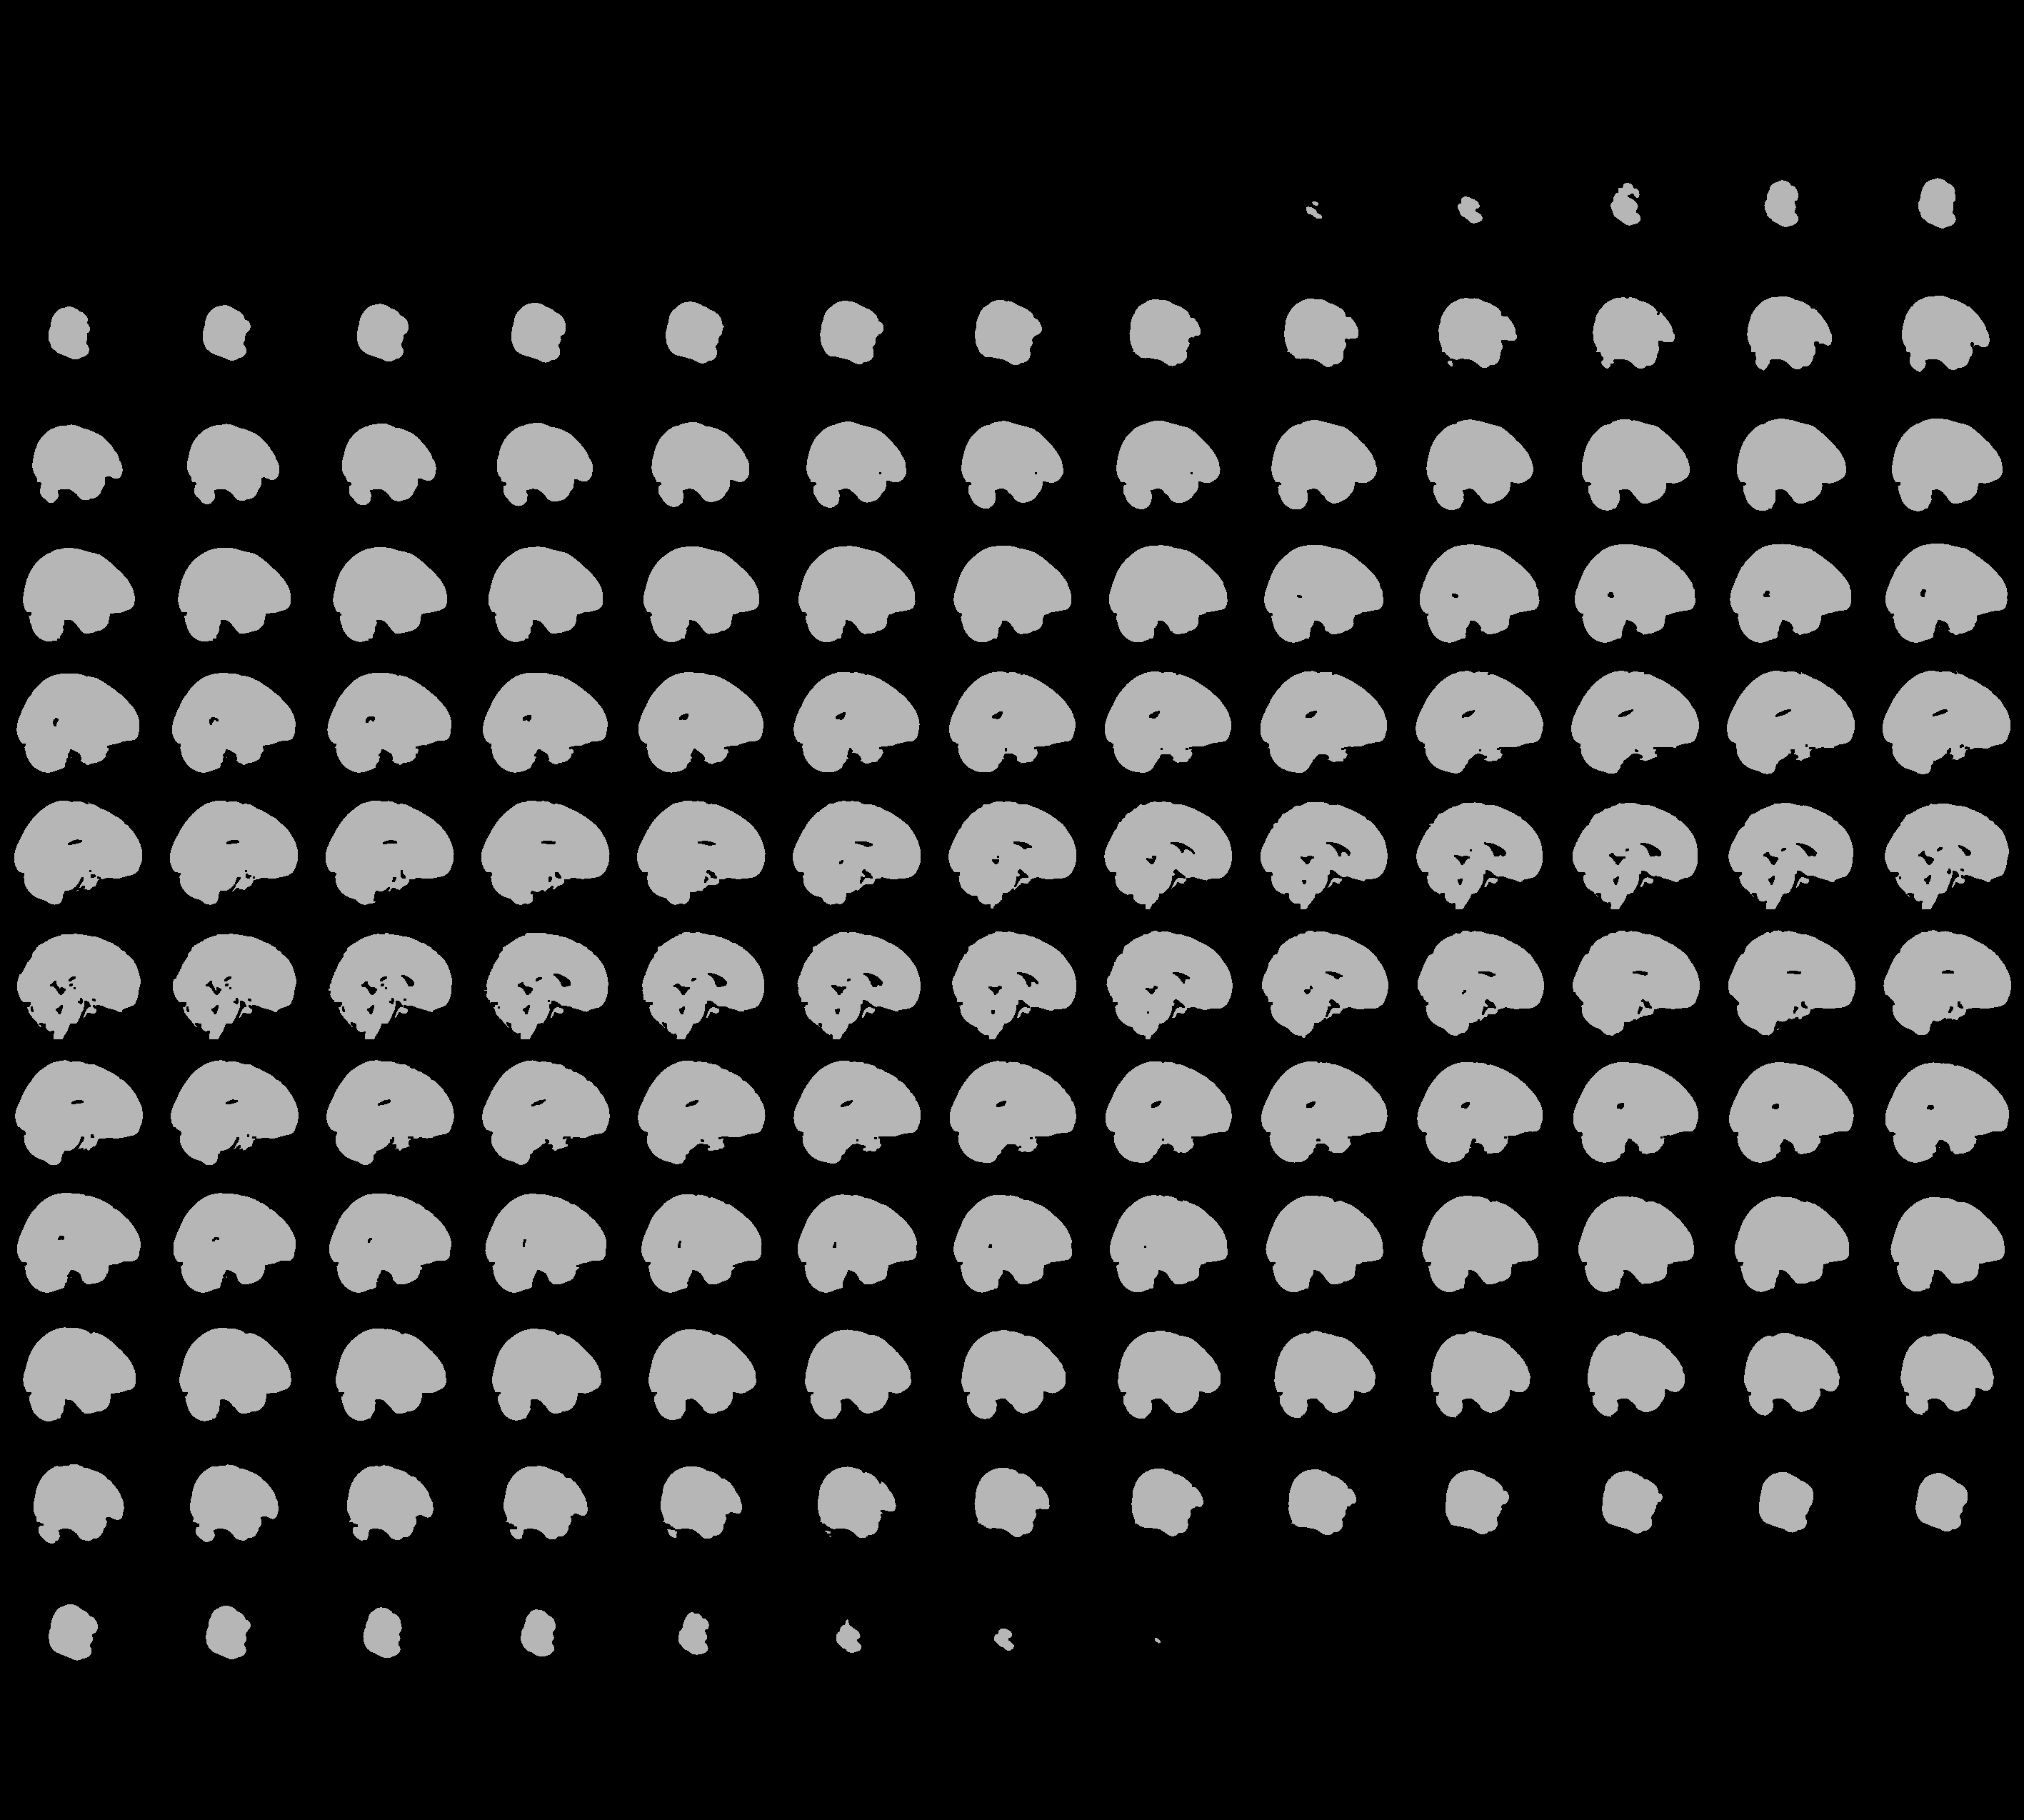
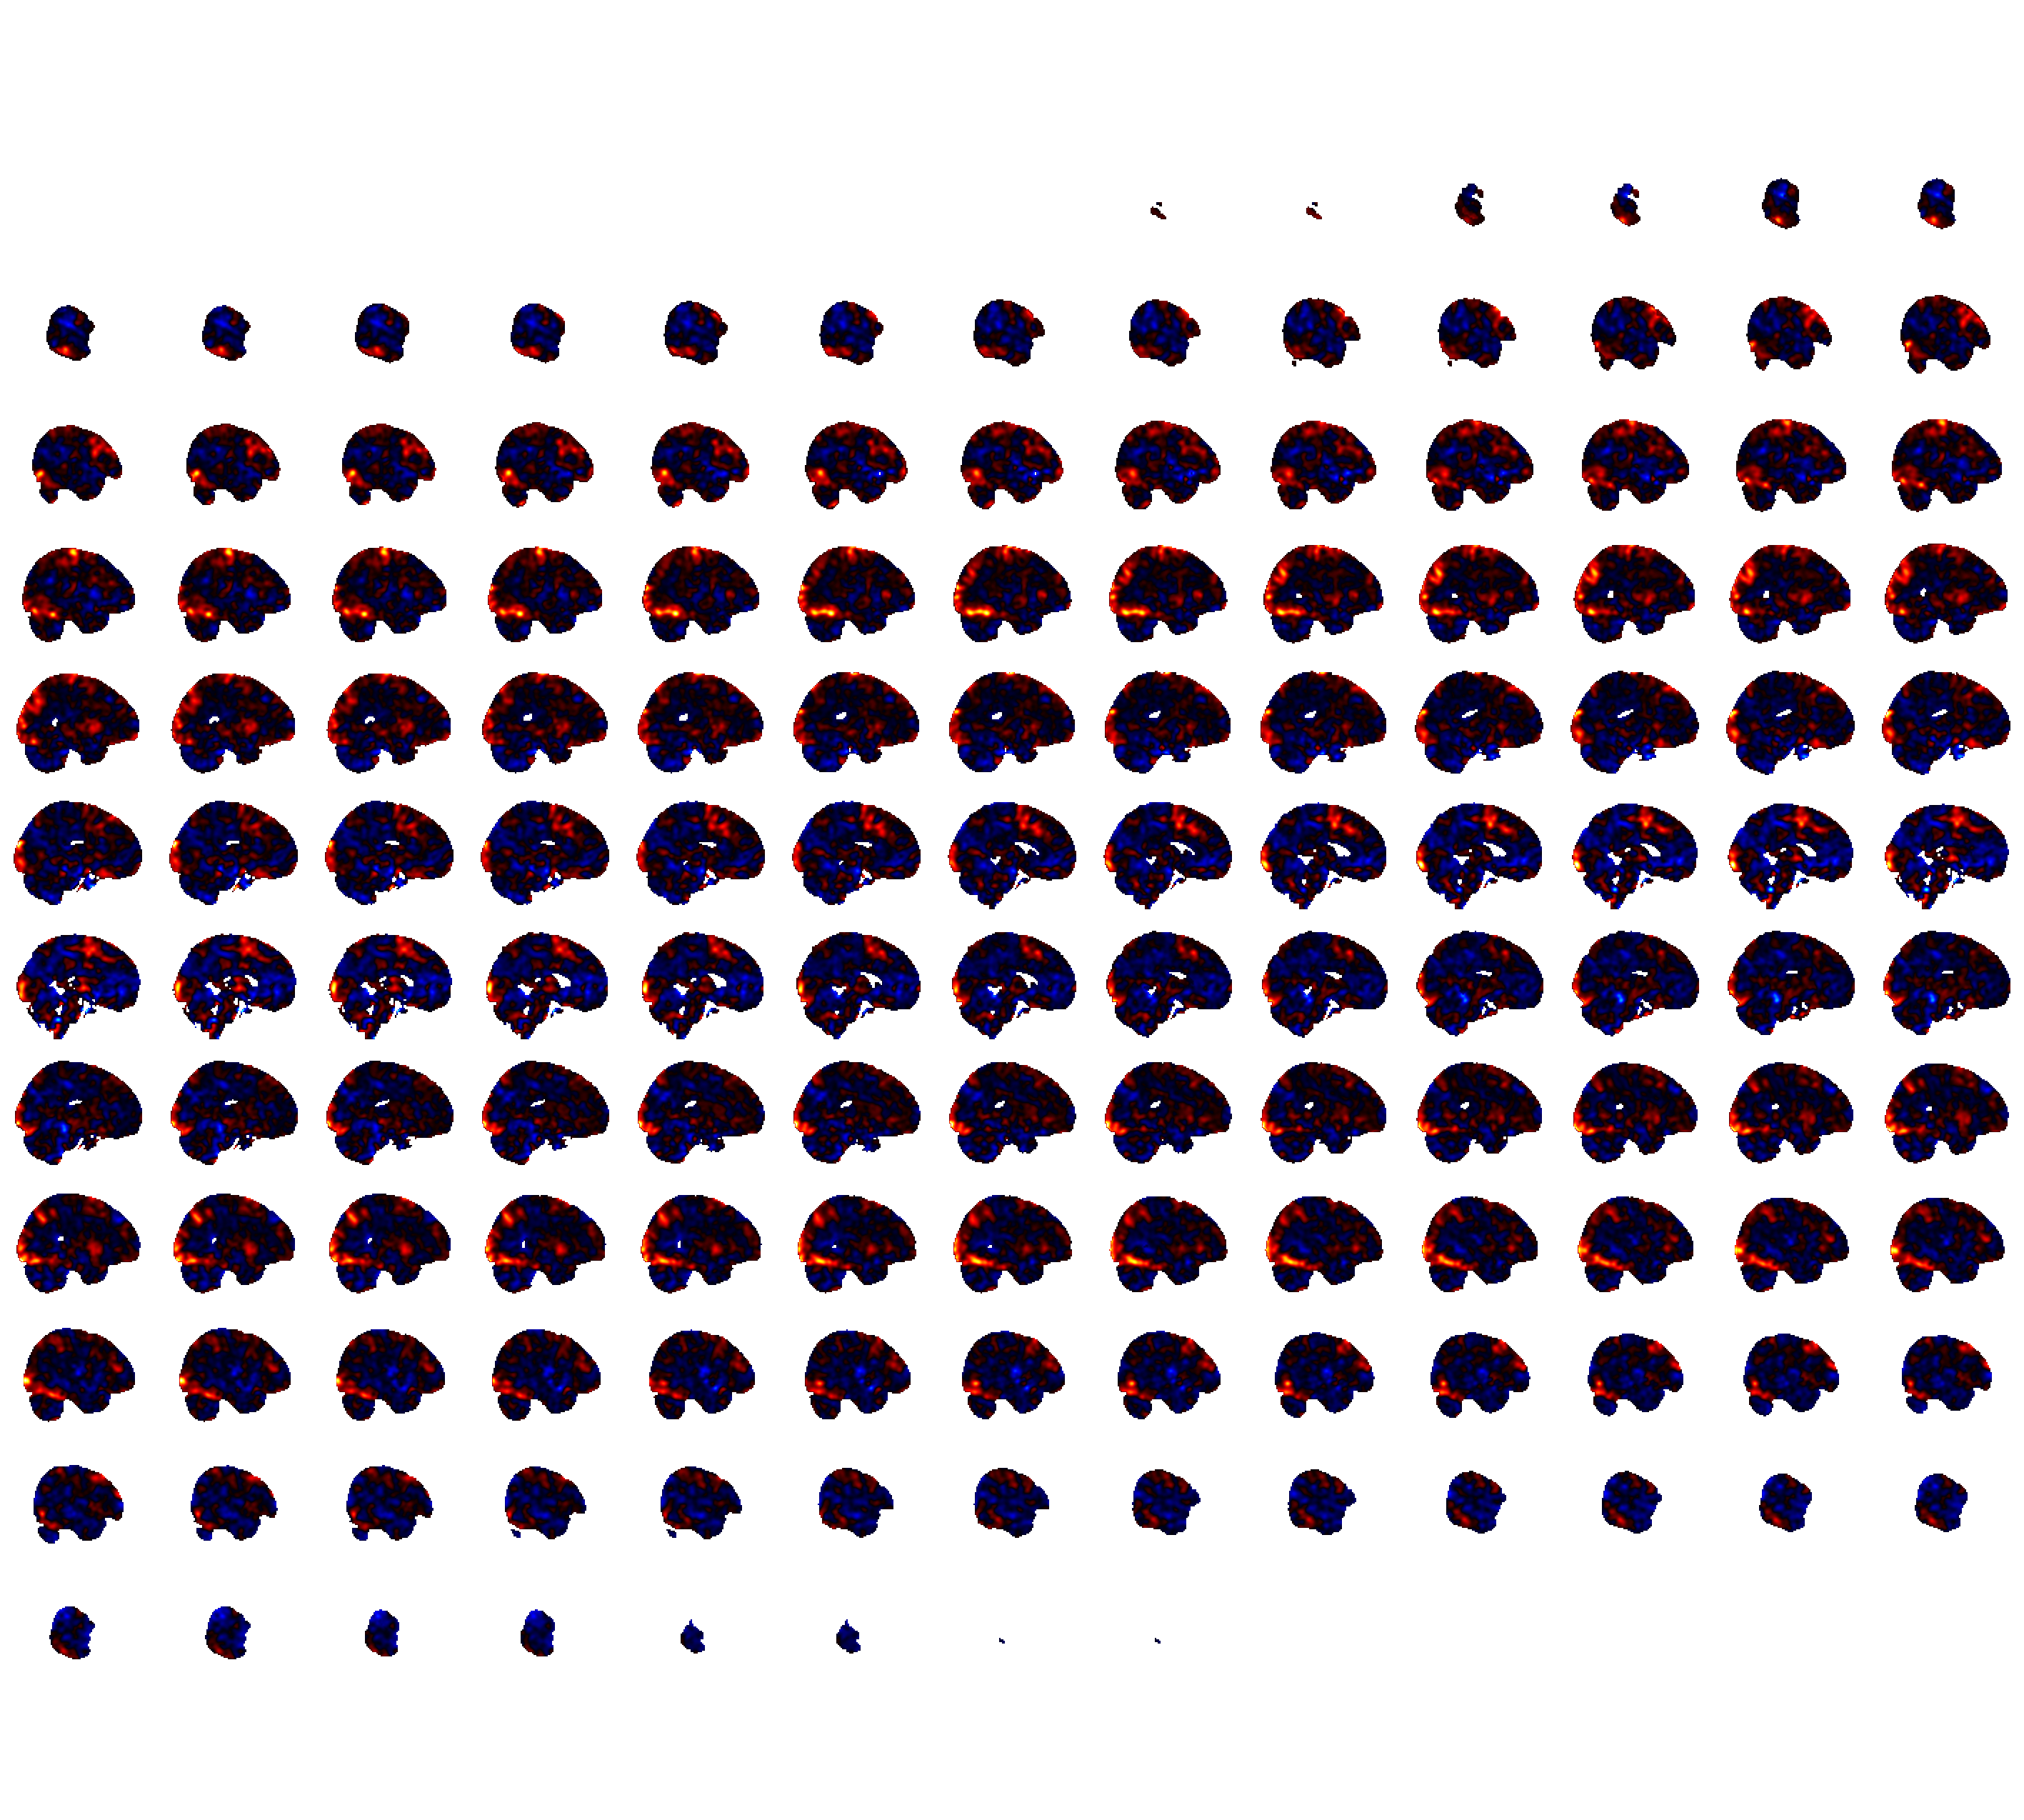

In [53]:
plotting.view_img(mean_img(subj_data),bg_img=generic_mask_filepath)

/home/bsmith16/.conda/envs/neuralsignature/lib/python3.8/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(



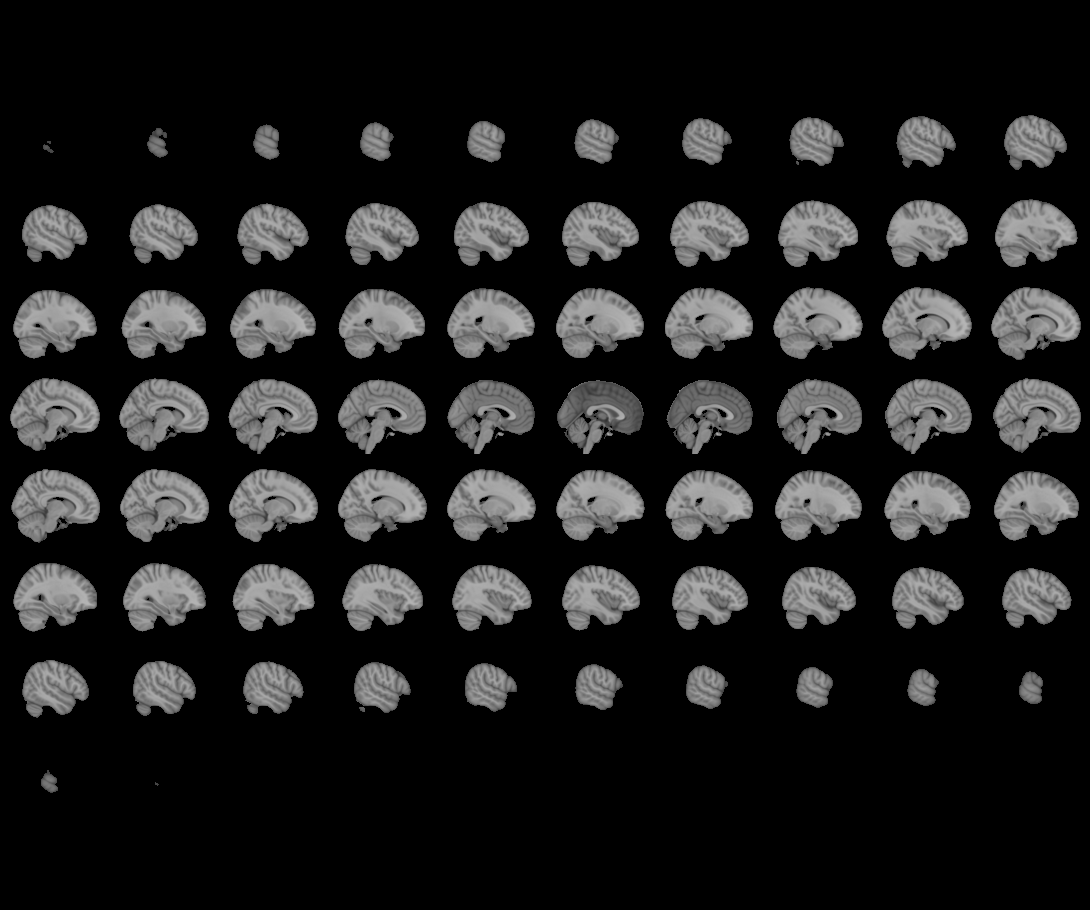
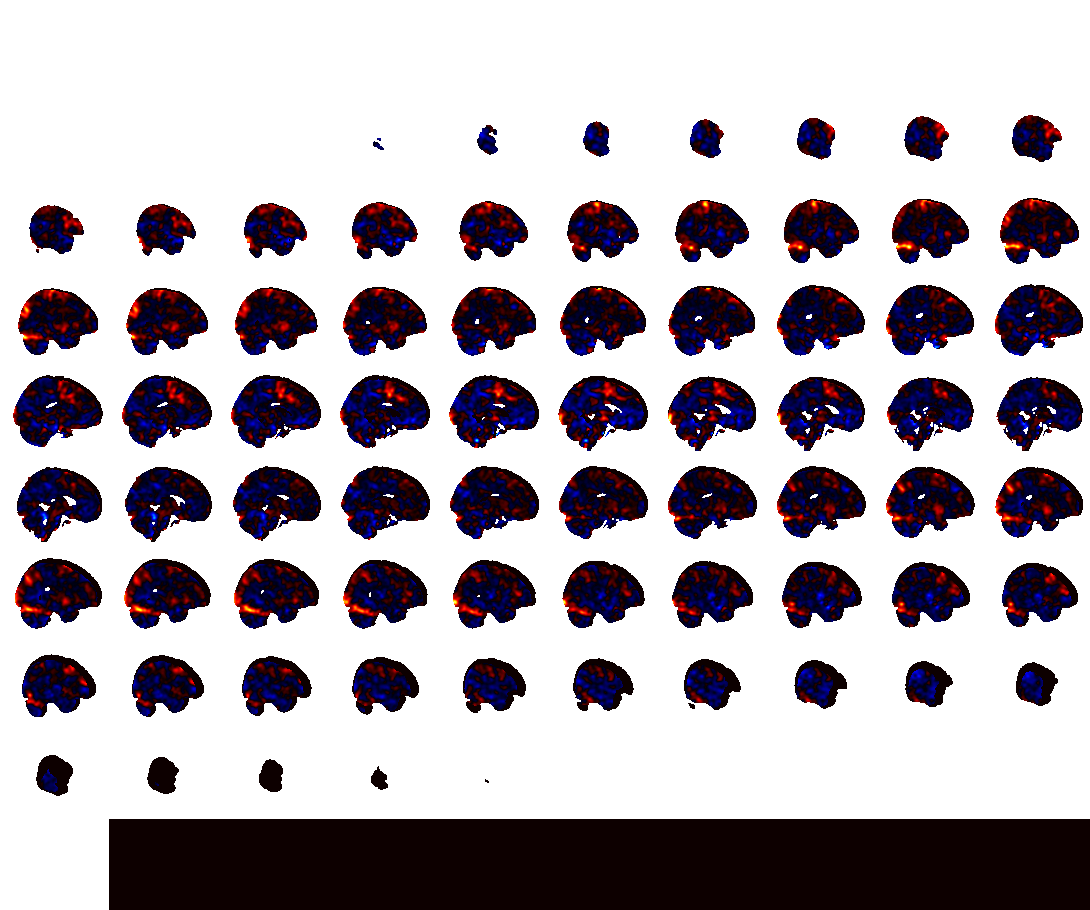

In [54]:
plotting.view_img(mean_img(subj_data))